<a href="https://colab.research.google.com/github/Tej-55/Fine-tuning-BeRT/blob/main/Fine_Tune_BERT_for_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed May 17 09:27:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [ ]:

#!pip install tensorflow
#!pip install tensorflow_hub

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)

2.12.0


In [ ]:
#!pip install -q tensorflow==2.3.0

In [ ]:
!git clone --depth 1 -b v2.12.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2042, done.
remote: Counting objects: 100% (2042/2042), done.
remote: Compressing objects: 100% (1412/1412), done.
remote: Total 2042 (delta 651), reused 1022 (delta 598), pack-reused 0
Receiving objects: 100% (2042/2042), 17.52 MiB | 21.06 MiB/s, done.
Resolving deltas: 100% (651/651), done.
Note: switching to '9fb4a4fbcd888616586ceffa1b8806ffe1126f54'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



## Download and Import the Quora Insincere Questions Dataset

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')


In [ ]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.12.0
Eager mode:  True
Hub version:  0.13.0
GPU is available


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
            compression='zip', low_memory=False)
df.shape

(1306122, 3)

In [ ]:
df.tail(20)

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


<Axes: ylabel='Frequency'>

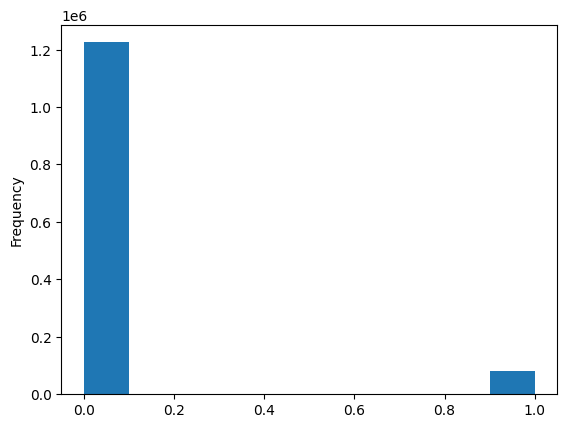

In [ ]:
df.target.plot(kind='hist')

## Create tf.data.Datasets for Training and Evaluation

In [ ]:
train_df, remain = train_test_split(df, random_state=42, train_size=0.0075, stratify=df.target.values)
valid_df, _ = train_test_split(remain, random_state=42,train_size=0.0075, stratify = remain.target.values)
train_df.shape, valid_df.shape

((9795, 3), (9722, 3))

In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'], train_df['target']))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df['question_text'], valid_df['target']))

  for text, label in train_data.take(1):
    print(text)
    print(label)

tf.Tensor(b'Why are unhealthy relationships so desirable?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Task 5: Download a Pre-trained BERT Model from TensorFlow Hub

In [ ]:
!pip install tensorflow_text
import tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 90.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3


In [ ]:
'''
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
'''

label_list = [0,1] # Label categories
max_seq_len = 128 # maximum length of (token) input sequences
train_batch_size = 32 

# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder_inputs = preprocessor(text_input)
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4", trainable=True)
outputs = encoder(encoder_inputs)
pooled_output = outputs["pooled_output"]    # [batch_size, 768].
sequence_output = outputs["sequence_output"]    # [batch_size, seq_length, 768].


In [ ]:
embedding_model = tf.keras.Model(text_input, encoder_inputs)
sentences = tf.constant(["Hi, how're you doing?"])
print(embedding_model(sentences))

{'input_word_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[ 101, 7632, 1010, 2129, 1005, 2128, 2017, 2725, 1029,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]], dtype=int32)>, 'input_mask': <tf.Tensor: shape=(1, 128), dtype=int3

## Create a TensorFlow Input Pipeline with `tf.data`

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = train_data.batch(train_batch_size, drop_remainder=True).shuffle(100).prefetch(tf.data.experimental.AUTOTUNE)

  # valid
  valid_data = valid_data.batch(train_batch_size, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)
  

In [ ]:
# train data spec
train_data.element_spec

(TensorSpec(shape=(32,), dtype=tf.string, name=None),
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

In [ ]:
# valid data spec
valid_data.element_spec

(TensorSpec(shape=(32,), dtype=tf.string, name=None),
 TensorSpec(shape=(32,), dtype=tf.int64, name=None))

## Fine-Tune BERT for Text Classification

In [ ]:
# Building the model
def create_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
  encoder_inputs = preprocessor(text_input)
  outputs = encoder(encoder_inputs)
  drop = tf.keras.layers.Dropout(0.6)(outputs["pooled_output"])
  output = tf.keras.layers.Dense(1, activation='sigmoid')(drop)
  return tf.keras.Model(inputs=text_input, outputs=output)

In [ ]:
#!pip install -U tensorflow==2.11.*
#!pip install -U tensorflow-text==2.11.*
#import tensorflow as tf
#import tensorflow_text as text

In [ ]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['input_2[0][0]']                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                

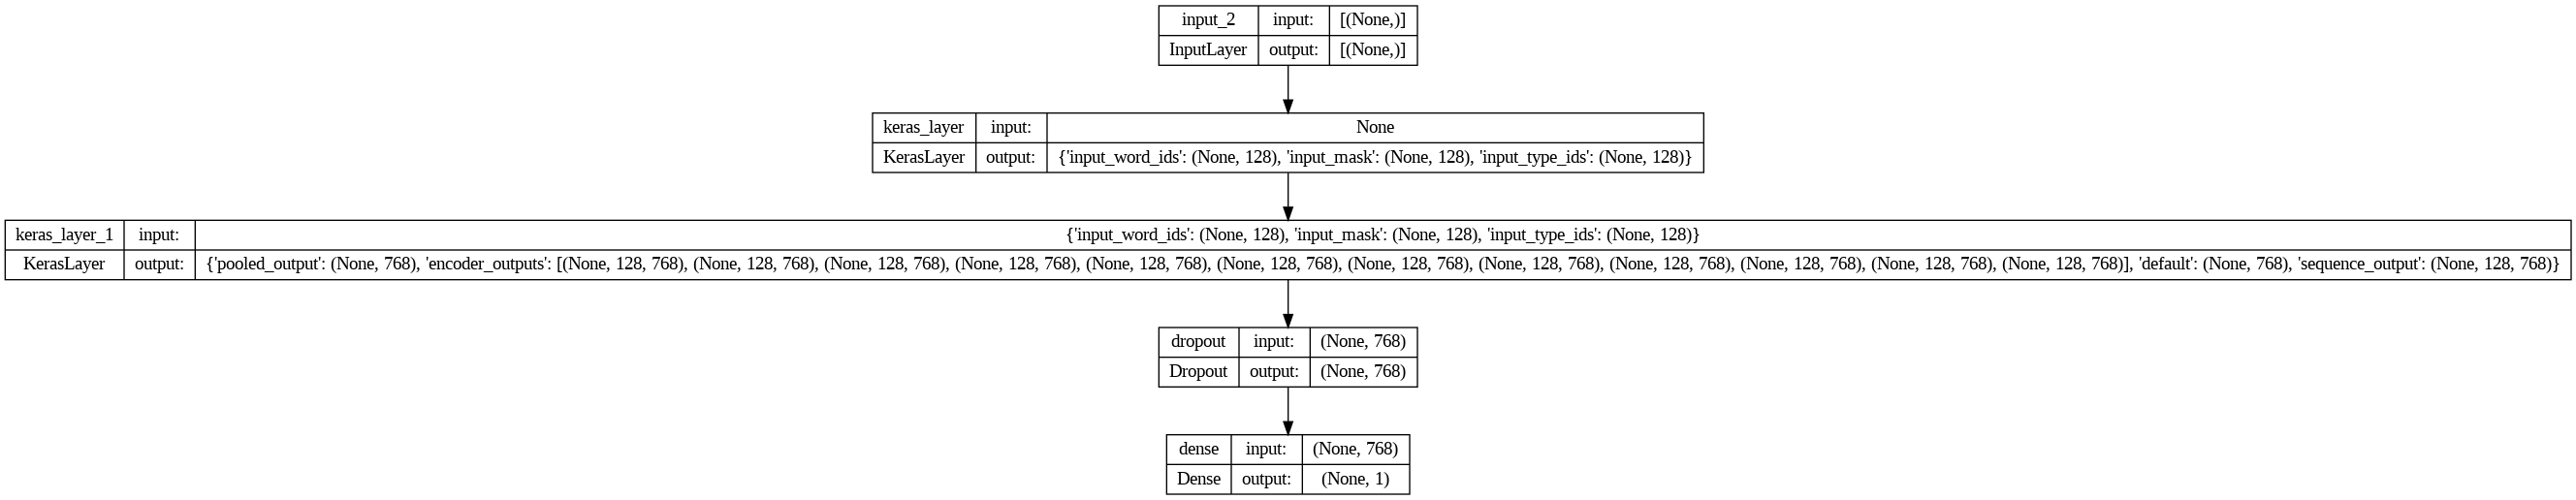

In [ ]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=96)

In [ ]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(32,), dtype=tf.string, name=None), TensorSpec(shape=(32,), dtype=tf.int64, name=None))>

In [ ]:
# Train model
epochs = 4
history = model.fit(train_data, validation_data=valid_data,
                    epochs=epochs, verbose=1)

Epoch 1/4
306/306 [==============================] - 431s 1s/step - loss: 0.2065 - binary_accuracy: 0.9246 - val_loss: 0.1235 - val_binary_accuracy: 0.9488
Epoch 2/4
306/306 [==============================] - 366s 1s/step - loss: 0.1133 - binary_accuracy: 0.9562 - val_loss: 0.1178 - val_binary_accuracy: 0.9551
Epoch 3/4
306/306 [==============================] - 405s 1s/step - loss: 0.0668 - binary_accuracy: 0.9763 - val_loss: 0.2092 - val_binary_accuracy: 0.9500
Epoch 4/4
306/306 [==============================] - 366s 1s/step - loss: 0.0301 - binary_accuracy: 0.9911 - val_loss: 0.1863 - val_binary_accuracy: 0.9549


## Evaluate the BERT Text Classification Model

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

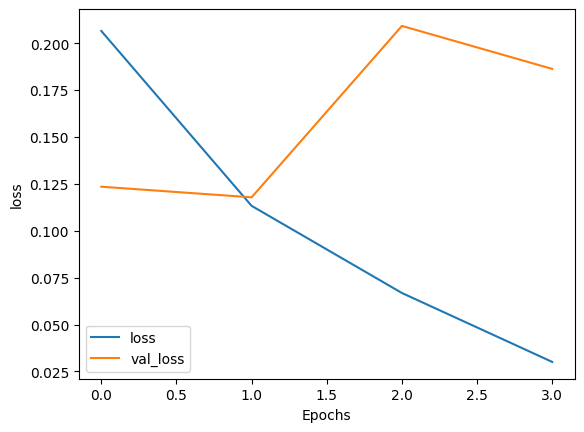

In [ ]:
plot_graphs(history, 'loss')

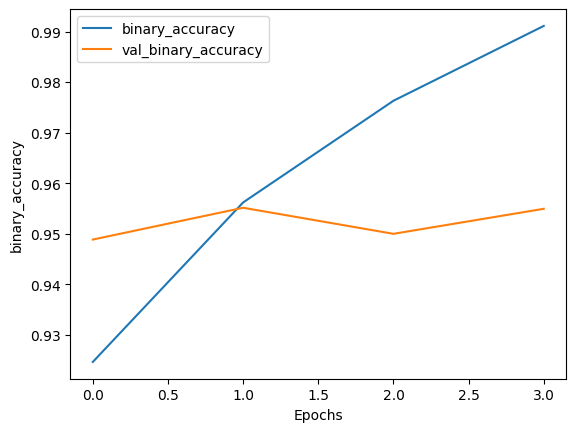

In [ ]:
plot_graphs(history, 'binary_accuracy')

In [ ]:
sample_example = ['Sentences']
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [0]*len(sample_example)))

test_data = test_data.batch(1)
preds = model.predict(test_data)
threshold = 0.5#
['Insinscere' if pred>=threshold else 'Sincerere' for pred in preds]

1/1 [==============================] - 1s 749ms/step


['Sincerere']